In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from datasets import load_dataset
import os 
import copy


In [107]:
dataset = load_dataset("gsm8k", "main")
train_questions = np.array(dataset["train"]["question"])
train_answers = np.array(dataset["train"]['answer'])

test_questions = np.array(dataset["test"]["question"])
test_answers = np.array(dataset["test"]['answer'])




In [31]:

def get_stats(train_name):
    train_accs_all = []
    perplexities_all = []


    ckpts = sorted([
    f for f in os.listdir("ckpts/"+train_name) if os.path.isdir(os.path.join("ckpts/"+train_name, f))
    ], key=lambda x: int(x.split('-')[1]))
    # print(ckpts)

    for ckpt in ckpts:
        try:
            train_correct = (np.load("ckpts/"+train_name+"/"+ckpt+ "/train_answer_types5_seed2_temp0.8.npy")==0)
            
        except:
            try: 
                train_correct = (np.load("ckpts/"+train_name+"/"+ckpt+ "/train_answer_types50_seed2_temp0.8.npy")==0)
            except: 
                try:
                    train_correct = (np.load("ckpts/"+train_name+"/"+ckpt+ "/train_answer_types10_seed2_temp0.8.npy")==0)
                except:
                    train_correct = (np.load("ckpts/"+train_name+"/"+ckpt+ "/train_answer_types5_seed2.npy")==0)
        train_accs = train_correct.mean(axis=-1)
        train_accs_all.append(train_accs)
        
        perplexities = np.load("ckpts/"+train_name+"/"+ckpt+ "/train_perplexities.npy")
        perplexities_all.append(perplexities)
        
    train_accs_all = np.array(train_accs_all)
    perplexities_all = np.array(perplexities_all)
    
    test_accs_all = []

    for ckpt in ckpts:
        try:
            test_accs = (np.load("ckpts/"+train_name+"/"+ckpt+ "/test_answer_types50_seed2.npy")==0)
        except:
            try:
                test_accs = (np.load("ckpts/"+train_name+"/"+ckpt+ "/test_answer_types50_seed2_temp0.8.npy")==0)
            except:
                try:
                    test_accs = (np.load("ckpts/"+train_name+"/"+ckpt+ "/test_answer_types5_seed2_temp0.8.npy")==0)
                except:
                    try:
                        test_accs = (np.load("ckpts/"+train_name+"/"+ckpt+ "/test_answer_types20_seed2_temp0.8.npy")==0)
                    except:
                        test_accs = (np.load("ckpts/"+train_name+"/"+ckpt+ "/test_answer_types5_seed2.npy")==0)
        test_accs_all.append(test_accs)

    test_accs_all = np.array(test_accs_all)
    
    return_dict = {}
    return_dict["train_accs_all"] = train_accs_all
    return_dict["perplexities_all"] = perplexities_all
    return_dict["test_accs_all"] = test_accs_all
    
    return return_dict




def get_ratios2(stats_dict, perp_threshold=-2.4):
    train_accs_all = stats_dict["train_accs_all"]
    perplexities_all = stats_dict["perplexities_all"]
    test_accs_all = stats_dict["test_accs_all"]
    
    memorization_mask = np.ones(train_accs_all.shape)*-1
    accs_all = np.ones(train_accs_all.shape)*-1
    
    for i in range(len(train_accs_all)):

        accs_all[i] =train_accs_all[i]
        
        memorization_mask[i] = (np.log(np.log((perplexities_all[i]))) >= perp_threshold)
    
    
    
    
    unmemorized_acc_cummax = np.array([(accs_all*memorization_mask)[:j+1].max(axis=0) for j in range(len(train_accs_all))])
    
    # print(unmemorized_acc_cummax.shape)
    # print(accs_all.shape)
    unmemorized_acc_cummax = (np.min([unmemorized_acc_cummax, accs_all], axis=0))
    unmemorized_acc_cummax_mean = unmemorized_acc_cummax.mean(axis=1)
    

    avg_test_acc = test_accs_all.mean(axis=-1).mean(axis=1)
    
    
    
    return_dict = {}
    
    
    return_dict["unmemorized_acc_cummax"] = unmemorized_acc_cummax_mean
    return_dict["unmemorized_acc_cummax_all"] = unmemorized_acc_cummax

    return_dict["avg_test_acc"] = avg_test_acc
            
    return return_dict


In [132]:
unmemorized_acc_cummax_all_s = []


# file_names = ["gsm8k_orig_6epochs_full_lr5e-07_bs128",
#               "gsm8k_orig_3epochs_full_lr5e-07_bs128",
#               "gsm8k_orig_6epochs_full_lr5e-05_bs128", 
#               "gsm8k_orig_3epochs_full_lr5e-05_bs128",
#               "gsm8k_orig_6epochs_full_lr0.0002_bs128",
#               "gsm8k_orig_3epochs_full_lr0.0002_bs128"]
file_names = ["gsm8k_orig_6epochs_full_lr5e-07_bs128",
              "gsm8k_orig_6epochs_full_lr5e-05_bs128",
              "gsm8k_orig_6epochs_full_lr0.0002_bs128"]
for file_name in file_names:
    print(file_name)

    stats_dict = get_stats(file_name)
    ratio_dict = get_ratios2(stats_dict, perp_threshold=-2.4)
    unmemorized_acc_cummax_all_s.append(ratio_dict["unmemorized_acc_cummax_all"][-1])

gsm8k_orig_6epochs_full_lr5e-07_bs128
gsm8k_orig_6epochs_full_lr5e-05_bs128
gsm8k_orig_6epochs_full_lr0.0002_bs128


In [125]:
num_newlines = np.array([len(train_answers[i].split("\n")) for i in range(len(train_answers))])

Text(0.5, 1.0, 'GSM8k Llama3 8B')

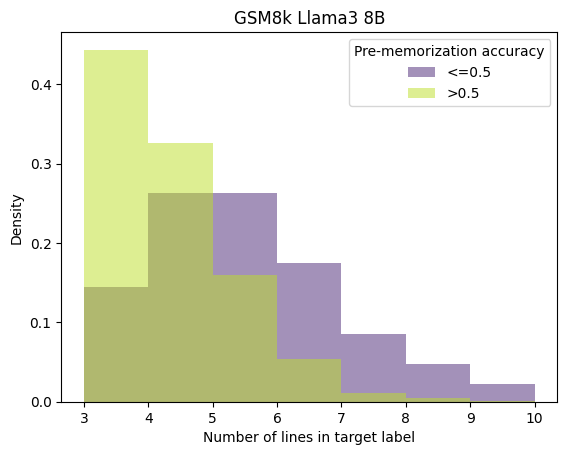

In [129]:
cmap = plt.get_cmap('viridis')


subsample_idxs = np.where(unmemorized_acc_cummax_all_s.mean(axis=0)<=0.5)[0]
plt.hist(num_newlines[subsample_idxs], bins=range(3, 11), density=True, alpha=0.5, color = cmap(0.1), label="<=0.5")


subsample_idxs = np.where(unmemorized_acc_cummax_all_s.mean(axis=0)>0.5)[0]
plt.hist(num_newlines[subsample_idxs], bins=range(3, 11), density=True, alpha=0.5, color = cmap(0.9), label=">0.5")

plt.xlabel("Number of lines in target label")
plt.ylabel("Density")
plt.legend(title="Pre-memorization accuracy")
plt.title("GSM8k Llama3 8B")

In [133]:
unmemorized_acc_cummax_all_s = np.array(unmemorized_acc_cummax_all_s)
unmemorized_acc_cummax_all_s_shuffle = copy.copy(unmemorized_acc_cummax_all_s)

for row in unmemorized_acc_cummax_all_s_shuffle:
    np.random.shuffle(row)
sorted_idxs = np.argsort(unmemorized_acc_cummax_all_s.mean(axis=0))
sorted_idxs_shuffle = np.argsort(unmemorized_acc_cummax_all_s_shuffle.mean(axis=0))

In [134]:
# sorted = unmemorized_acc_cummax_all_s_shuffle[:, sorted_idxs_shuffle]
sorted_array = unmemorized_acc_cummax_all_s[:, sorted_idxs]

sorted_expanded = []

for row in sorted_array:
    for _ in range(1000):
        sorted_expanded.append(row)

sorted_expanded = np.array(sorted_expanded)

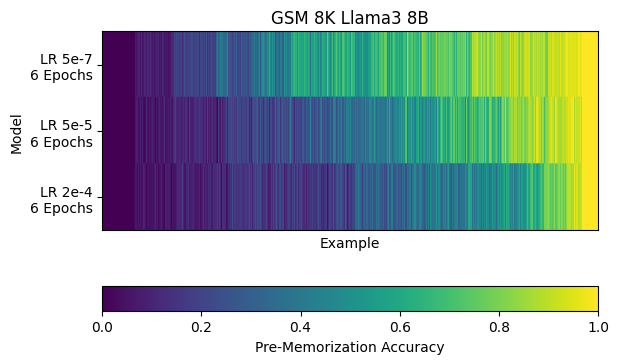

In [135]:
plt.imshow(sorted_expanded)
plt.ylabel("Model")
plt.xlabel("Example")
plt.yticks(ticks=[500, 1500, 2500], labels=["LR 5e-7\n6 Epochs", "LR 5e-5\n6 Epochs", "LR 2e-4\n6 Epochs"])
plt.xticks(ticks = [])
plt.title("GSM 8K Llama3 8B") 
plt.colorbar(label = "Pre-Memorization Accuracy", orientation="horizontal")

In [193]:

unmemorized_acc_cummax_all_adaptive= []
num_examples_adaptive = []


train_name = f"gsm8k_amrith_3epochs_{0}copies_lr2e-05_bs128"
stats_dict = get_stats(train_name)
ratio_dict = get_ratios2(stats_dict, perp_threshold=-2.4)
unmemorized_acc_cummax_all_adaptive.append(ratio_dict["unmemorized_acc_cummax_all"][-1])
num_examples_adaptive.append(len(train_questions)+len(np.load(f"ckpts/{train_name}/amrith_data_subsample_idxs.npy")))
    
for num_itrs in [0, 2, 4]:
    train_name = "0copies_threshold0.75_1newcopies"
    for j in range(num_itrs):
        train_name = "prev{"+train_name+"}"
    train_name = "gsm8k_amrith_3epochs_"+train_name+"_lr2e-05_bs128"
    
    stats_dict = get_stats(train_name)
    ratio_dict = get_ratios2(stats_dict, perp_threshold=-2.4)
    unmemorized_acc_cummax_all_adaptive.append(ratio_dict["unmemorized_acc_cummax_all"][-1])
    num_examples_adaptive.append(len(train_questions)+len(np.load(f"ckpts/{train_name}/amrith_data_subsample_idxs.npy")))
    
unmemorized_acc_cummax_all_adaptive = np.array(unmemorized_acc_cummax_all_adaptive)
num_examples_adaptive = np.array(num_examples_adaptive)

unmemorized_acc_cummax_all_uniform = []
num_examples_uniform = []
for num_copies in [0, 1, 3, 7]:
    train_name = f"gsm8k_amrith_3epochs_{num_copies}copies_lr2e-05_bs128"
    stats_dict = get_stats(train_name)
    ratio_dict = get_ratios2(stats_dict, perp_threshold=-2.4)
    unmemorized_acc_cummax_all_uniform.append(ratio_dict["unmemorized_acc_cummax_all"][-1])
    num_examples_uniform.append(len(train_questions)+len(np.load(f"ckpts/{train_name}/amrith_data_subsample_idxs.npy")))

unmemorized_acc_cummax_all_uniform = np.array(unmemorized_acc_cummax_all_uniform)
num_examples_uniform = np.array(num_examples_uniform)

# unmemorized_acc_cummax_all_s.mean(axis=0)

In [157]:
unmemorized_acc_cummax_all_adaptive[:, np.where(unmemorized_acc_cummax_all_s.mean(axis=0)>0.75)[0]].mean(axis=1)



array([0.91630037, 0.91620879, 0.91932234, 0.93131868, 0.9246337 ])

In [162]:
unmemorized_acc_cummax_all_uniform[:, np.where(unmemorized_acc_cummax_all_s.mean(axis=0)>0.75)[0]].mean(axis=1)


array([0.88113553, 0.91043956, 0.92051282, 0.9271978 , 0.94285714])

In [164]:
unmemorized_acc_cummax_all_adaptive[:, np.where(unmemorized_acc_cummax_all_s.mean(axis=0)<=0.25)[0]].mean(axis=1)


array([0.40986784, 0.40568282, 0.42995595, 0.46823789, 0.47414097])

In [167]:
unmemorized_acc_cummax_all_uniform[:, np.where(unmemorized_acc_cummax_all_s.mean(axis=0)<=0.25)[0]].mean(axis=1)


array([0.32088106, 0.3776652 , 0.41449339, 0.43907489, 0.51105727])

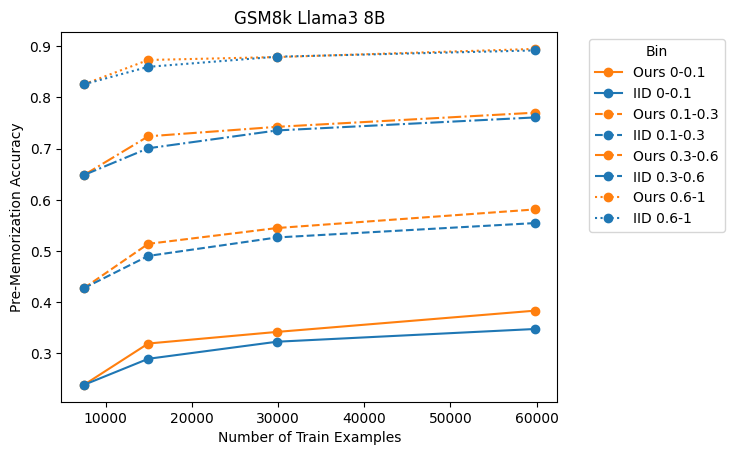

In [237]:
bins = [0, 0.1, 0.3, 0.6, 1]



metric_adaptive = []
metric_uniform = []

linestyles = ["o-", "o--", "o-.", "o:"]

bin_labels = ["0-0.1", "0.1-0.3", "0.3-0.6", "0.6-1"]

for i in range(len(bins)-1):
    threshold1 = bins[i]
    threshold2 = bins[i+1]

    # # plt.plot(num_examples_adaptive, a-b, "o-")
    plt.plot(num_examples_adaptive, unmemorized_acc_cummax_all_adaptive[:, np.where((unmemorized_acc_cummax_all_s.mean(axis=0)>=threshold1)*(unmemorized_acc_cummax_all_s.mean(axis=0)<=threshold2))[0]].mean(axis=1),linestyles[i],  label="Ours "+bin_labels[i], color="C1")
    plt.plot(num_examples_uniform, unmemorized_acc_cummax_all_uniform[:, np.where((unmemorized_acc_cummax_all_s.mean(axis=0)>=threshold1)*(unmemorized_acc_cummax_all_s.mean(axis=0)<=threshold2))[0]].mean(axis=1), linestyles[i], label="IID "+bin_labels[i], color="C0")
    # metric_adaptive.append(unmemorized_acc_cummax_all_adaptive[:, np.where((unmemorized_acc_cummax_all_s.mean(axis=0)>=threshold1)*(unmemorized_acc_cummax_all_s.mean(axis=0)<=threshold2))[0]].mean(axis=1))
    # metric_uniform.append(unmemorized_acc_cummax_all_uniform[:, np.where((unmemorized_acc_cummax_all_s.mean(axis=0)>=threshold1)*(unmemorized_acc_cummax_all_s.mean(axis=0)<=threshold2))[0]].mean(axis=1))


plt.xlabel("Number of Train Examples")
plt.ylabel("Pre-Memorization Accuracy")
plt.title("GSM8k Llama3 8B")

# add legend outside of plot
plt.legend(title="Bin", bbox_to_anchor=(1.05, 1), loc='upper left')

In [77]:
dataset = load_dataset("hendrycks/competition_math")

train_questions = np.array(dataset["train"]["problem"])
train_answers = np.array(dataset["train"]['solution'])



/data/katie_kang/miniconda3/envs/trlx2/lib/python3.9/site-packages/datasets/load.py:1461: FutureWarning: The repository for hendrycks/competition_math contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/hendrycks/competition_math
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [92]:

levels = []

for level in dataset["train"]["level"]:
    if level[-1] == "?":
        levels.append(-1)
    else:
        levels.append(int(level[-1]))

In [83]:
unmemorized_acc_cummax_all_s = []


# file_names = ["gsm8k_orig_6epochs_full_lr5e-07_bs128",
#               "gsm8k_orig_3epochs_full_lr5e-07_bs128",
#               "gsm8k_orig_6epochs_full_lr5e-05_bs128", 
#               "gsm8k_orig_3epochs_full_lr5e-05_bs128",
#               "gsm8k_orig_6epochs_full_lr0.0002_bs128",
#               "gsm8k_orig_3epochs_full_lr0.0002_bs128"]
file_names = ["math_orig_6epochs_full_lr5e-07_bs24",
              "math_orig_6epochs_full_lr5e-05_bs24",
              "math_orig_6epochs_full_lr0.0002_bs24"]
for file_name in file_names:
    print(file_name)

    stats_dict = get_stats(file_name)
    ratio_dict = get_ratios2(stats_dict, perp_threshold=-2.4)
    unmemorized_acc_cummax_all_s.append(ratio_dict["unmemorized_acc_cummax_all"][-1])

math_orig_6epochs_full_lr5e-07_bs24
math_orig_6epochs_full_lr5e-05_bs24
math_orig_6epochs_full_lr0.0002_bs24


In [84]:
unmemorized_acc_cummax_all_s = np.array(unmemorized_acc_cummax_all_s)
unmemorized_acc_cummax_all_s_shuffle = copy.copy(unmemorized_acc_cummax_all_s)

for row in unmemorized_acc_cummax_all_s_shuffle:
    np.random.shuffle(row)
sorted_idxs = np.argsort(unmemorized_acc_cummax_all_s.mean(axis=0))
sorted_idxs_shuffle = np.argsort(unmemorized_acc_cummax_all_s_shuffle.mean(axis=0))

(array([4324., 1074.,  999.,  498.,  265.,  206.,   61.,   47.,   21.,
           5.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

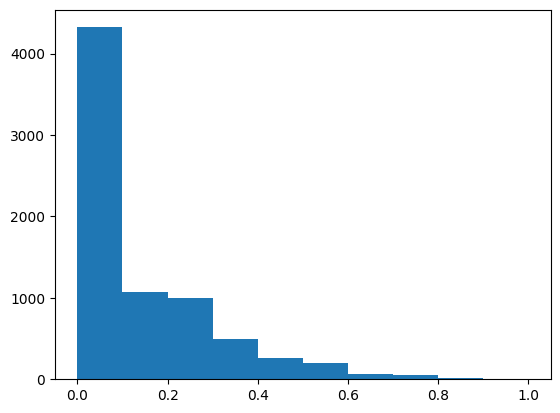

In [88]:
plt.hist(unmemorized_acc_cummax_all_s.mean(axis=0))

(array([2.000e+00, 0.000e+00, 0.000e+00, 5.640e+02, 0.000e+00, 1.348e+03,
        1.592e+03, 0.000e+00, 1.690e+03, 2.304e+03]),
 array([-1. , -0.4,  0.2,  0.8,  1.4,  2. ,  2.6,  3.2,  3.8,  4.4,  5. ]),
 <BarContainer object of 10 artists>)

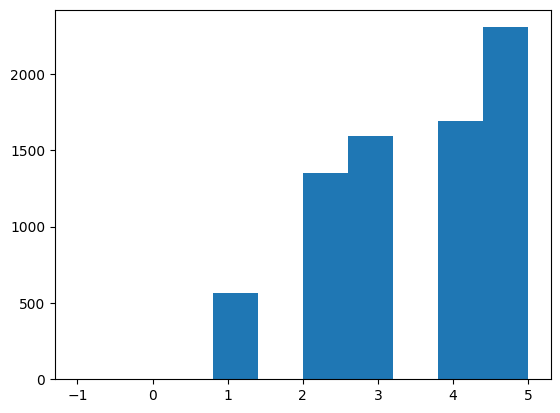

In [100]:
plt.hist(levels)

In [94]:
levels

array([5, 5, 3, ..., 2, 2, 2])

Text(0.5, 1.0, 'MATH Llama3 8B')

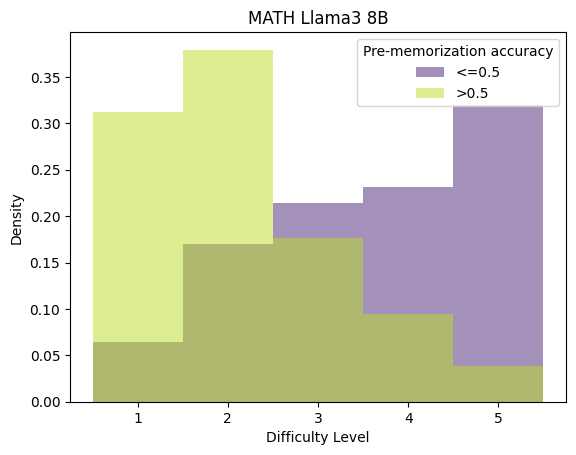

In [104]:
cmap = plt.get_cmap('viridis')

levels = np.array(levels)
subsample_idxs = np.where(unmemorized_acc_cummax_all_s.mean(axis=0)<=0.5)[0]
plt.hist(levels[subsample_idxs], bins=np.arange(6)+0.5, density=True, alpha=0.5, color = cmap(0.1), label="<=0.5")


subsample_idxs = np.where(unmemorized_acc_cummax_all_s.mean(axis=0)>0.5)[0]
plt.hist(levels[subsample_idxs], bins=np.arange(6)+0.5, density=True, alpha=0.5, color = cmap(0.9), label=">0.5")

plt.xlabel("Difficulty Level")
plt.ylabel("Density")
plt.legend(title="Pre-memorization accuracy")
plt.title("MATH Llama3 8B")

In [34]:
# sorted = unmemorized_acc_cummax_all_s_shuffle[:, sorted_idxs_shuffle]
sorted_array = unmemorized_acc_cummax_all_s[:, sorted_idxs]

sorted_expanded = []

for row in sorted_array:
    for _ in range(1000):
        sorted_expanded.append(row)

sorted_expanded = np.array(sorted_expanded)

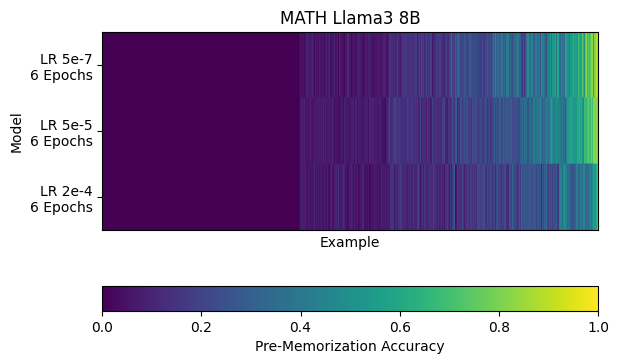

In [36]:
plt.imshow(sorted_expanded)
plt.ylabel("Model")
plt.xlabel("Example")
plt.yticks(ticks=[500, 1500, 2500], labels=["LR 5e-7\n6 Epochs", "LR 5e-5\n6 Epochs", "LR 2e-4\n6 Epochs"])
plt.xticks(ticks = [])
plt.title("MATH Llama3 8B") 
plt.colorbar(label = "Pre-Memorization Accuracy", orientation="horizontal")